In [1]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

# Function to extract features from each photo in the directory
def extract_features(directory):
    # Load the VGG16 model
    model = VGG16()

    # Re-structure the model to remove the classification layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # Summarize the model
    print(model.summary())

    # Initialize an empty dictionary to store the features
    features = dict()

    # Loop through all the image files in the directory
    for name in listdir(directory):
        # Load an image from file
        filename = directory + '/' + name
        img = image.load_img(filename, target_size=(224, 224))

        # Convert the image pixels to a numpy array
        img_array = image.img_to_array(img)

        # Reshape data for the model
        img_array = img_array.reshape((1, img_array.shape[0], img_array.shape[1], img_array.shape[2]))

        # Prepare the image for the VGG model
        img_array = preprocess_input(img_array)

        # Get features from the VGG model
        feature = model.predict(img_array, verbose=0)

        # Get image ID (remove the file extension)
        image_id = name.split('.')[0]

        # Store the feature in the dictionary
        features[image_id] = feature

        print('>%s' % name)

    return features

# Extract features from all images in the directory
directory = 'C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/'
features = extract_features(directory)

# Print the number of extracted features
print('Extracted Features: %d' % len(features))

# Save the features to a file using pickle
dump(features, open('features.pkl', 'wb'))





Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [2]:
import string

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename='C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [3]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.callbacks import ModelCheckpoint

# Load the document into memory
def load_doc(filename):
    # Open the file as read only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

# Load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # Process line by line
    for line in doc.split('\n'):
        # Skip empty lines
        if len(line) < 1:
            continue
        # Get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# Load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # Load the document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # Split line by white space
        tokens = line.split()
        # Split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # Skip images not in the set
        if image_id in dataset:
            # Create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # Wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # Store
            descriptions[image_id].append(desc)
    return descriptions

# Load photo features
def load_photo_features(filename, dataset):
    # Load all features
    all_features = load(open(filename, 'rb'))
    # Filter features
    features = {k: all_features[k] for k in dataset}
    return features

# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# Calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# Create sequences of images, input sequences, and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # Walk through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
            # Split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

# Define the captioning model
def define_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Decoder model
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # Summarize model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

# Data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # Loop forever over images
    while 1:
        for key, desc_list in descriptions.items():
            # Retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq], out_word

# Load training dataset (6K)
filename = 'C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# Descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# Photo features
train_features = load_photo_features('features.pkl', train)
print('Photos: train=%d' % len(train_features))
# Prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# Determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# Define the model
model = define_model(vocab_size, max_length)
# Train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
    # Create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # Fit for one epoch
    model.fit_generator(generator, epochs=15, steps_per_epoch=steps, verbose=1)
    # Save model
    model.save('model_' + str(i) + '.keras')


Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              1940224   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']  

C:\Users\narot\AppData\Local\Temp\ipykernel_37756\3114984894.py:171: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=15, steps_per_epoch=steps, verbose=1)



6000/6000 [==============================] - 985s 163ms/step - loss: 4.6920
Epoch 2/15
6000/6000 [==============================] - 1310s 218ms/step - loss: 3.8811
Epoch 3/15
6000/6000 [==============================] - 1667s 278ms/step - loss: 3.6274
Epoch 4/15
6000/6000 [==============================] - 1634s 272ms/step - loss: 3.5047
Epoch 5/15
6000/6000 [==============================] - 1659s 277ms/step - loss: 3.3723
Epoch 6/15
6000/6000 [==============================] - 1654s 276ms/step - loss: 3.2995
Epoch 7/15
6000/6000 [==============================] - 1701s 283ms/step - loss: 3.2728
Epoch 8/15
6000/6000 [==============================] - 1571s 262ms/step - loss: 3.2100
Epoch 9/15
6000/6000 [==============================] - 1552s 259ms/step - loss: 3.1770
Epoch 10/15
6000/6000 [==============================] - 1591s 265ms/step - loss: 3.1503
Epoch 11/15
6000/6000 [==============================] - 1627s 271ms/step - loss: 3.1381
Epoch 12/15
6000/6000 [==================

In [7]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
            # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# prepare tokenizer on train set

# load training dataset (6K)
filename = 'C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set

# load test set
filename = 'C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))

# load the model
filename = 'model_0.keras'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 2000
Descriptions: test=2000
Photos: test=2000
BLEU-1: 0.520274
BLEU-2: 0.275969
BLEU-3: 0.188726
BLEU-4: 0.089282


In [1]:
from keras.preprocessing.text import Tokenizer
from pickle import dump

# Load the document into memory
def load_doc(filename):
    # Open the file as read only
    file = open(filename, 'r')
    # Read all text
    text = file.read()
    # Close the file
    file.close()
    return text

# Load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # Process line by line
    for line in doc.split('\n'):
        # Skip empty lines
        if len(line) < 1:
            continue
        # Get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# Load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # Load the document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # Split line by white space
        tokens = line.split()
        # Split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # Skip images not in the set
        if image_id in dataset:
            # Create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # Wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # Store
            descriptions[image_id].append(desc)
    return descriptions

# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# Load training dataset (6K)
filename = 'C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# Descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# Prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# Save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))



Dataset: 6000
Descriptions: train=6000


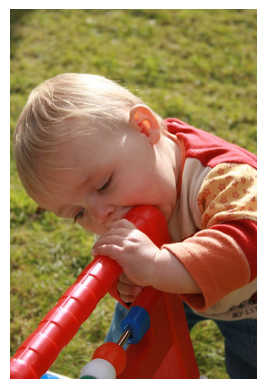

startseq young boy in red shirt is playing with his head endseq


In [19]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
from matplotlib import pyplot as plt
from PIL import Image

# Function to extract features from each photo in the directory
def extract_features(filename):
    # Load the VGG16 model
    model = VGG16()
    # Restructure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # Load the photo
    image = load_img(filename, target_size=(224, 224))
    # Convert the image pixels to a numpy array
    image = img_to_array(image)
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the VGG model
    image = preprocess_input(image)
    # Get features
    feature = model.predict(image, verbose=0)
    return feature

# Function to map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # Seed the generation process
    in_text = 'startseq'
    # Iterate over the whole length of the sequence
    for i in range(max_length):
        # Integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # Convert probability to integer
        yhat = argmax(yhat)
        # Map integer to word
        word = word_for_id(yhat, tokenizer)
        # Stop if we cannot map the word
        if word is None:
            break
        # Append as input for generating the next word
        in_text += ' ' + word
        # Stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# Load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# Pre-define the max sequence length (from training)
max_length = 34
# Load the pre-trained model
model = load_model('model_0.keras')
# Load and prepare the photograph
image_path = 'C:\\Users\\narot\\OneDrive\\Desktop\\correct image caption\\baby.jpg'
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/3711826708_bba64fb1e1.jpg
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/2090545563_a4e66ec76b.jpg
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/111497985_38e9f88856.jpg
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/3393035454_2d2370ffd4.jpg  unused part
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/263850317_5bb3a18a08.jpg   blur
#C:/Users/narot/OneDrive/Desktop/Flickr8k_Dataset (1)/Flicker8k_Dataset/2501742763_b2cb322087.jpg  unused part

#C:\\Users\\narot\\OneDrive\\Desktop\\correct image caption\\baby.jpg
#C:\\Users\\narot\\OneDrive\\Desktop\\correct image caption\\play.jpg
#C:\\Users\\narot\\OneDrive\\Desktop\\correct image caption\\new.jpg
#C:\\Users\\narot\\OneDrive\\Desktop\\correct image caption\\mountain.jpg

photo = extract_features(image_path)
# Generate description
description = generate_desc(model, tokenizer, photo, max_length)

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

# Print the generated description
print(description)
